# Task 1 ：Replicate the experiment by adding noise to validate the noise resistance of the binary classification method.
Result download：https://huggingface.co/datasets/JimXie/IIoTset/blob/main/performance.tar.gz

1. The selected dataset contains anomalous data.
2. Some of the selected features are ineffective.
3. Through feature map filtering, 3-4 key features can be identified, which achieve results close to using all the features.
4. The chosen features are unstable and unsuitable for use in real-world scenarios.

In [ ]:
import os,sys
sys.path.append("./share")
sys.path.append("./common")
sys.path.append("./ml")
from Config import g_data_root
import pandas as pd
import numpy as np
import warnings,logging,re
from SHVisualize import CSHVisualize
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from SHModelClassify import CSHModelClassify
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHFeatureSelect import CSHFeature
from IoTNoise import CIoTNoise
import seaborn as sns
import h2o
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
tqdm.pandas()
import warnings
warnings.simplefilter(action='ignore')
h2o.init(nthreads = -1, verbose=False)
np.random.seed(42)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [21]:
def is_valid_ip(ip_str):
    ip_pattern = re.compile(r'^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')
    if ip_pattern.match(ip_str):
        octets = ip_str.split('.')
        for octet in octets:
            if int(octet) > 255:
                return False
        return True
    else:
        return False

def is_valid_time(time_str):
    tmp = time_str.strip()
    tmp = tmp[:-3]
    try:
        datetime.strptime(tmp, '%Y %H:%M:%S.%f')
        return True
    except ValueError:
        return False

In [22]:
df = pd.read_csv("%s/raw/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv"%g_data_root,low_memory=False)

# Raw features

In [23]:
df.keys().tolist()

['frame.time',
 'ip.src_host',
 'ip.dst_host',
 'arp.dst.proto_ipv4',
 'arp.opcode',
 'arp.hw.size',
 'arp.src.proto_ipv4',
 'icmp.checksum',
 'icmp.seq_le',
 'icmp.transmit_timestamp',
 'icmp.unused',
 'http.file_data',
 'http.content_length',
 'http.request.uri.query',
 'http.request.method',
 'http.referer',
 'http.request.full_uri',
 'http.request.version',
 'http.response',
 'http.tls_port',
 'tcp.ack',
 'tcp.ack_raw',
 'tcp.checksum',
 'tcp.connection.fin',
 'tcp.connection.rst',
 'tcp.connection.syn',
 'tcp.connection.synack',
 'tcp.dstport',
 'tcp.flags',
 'tcp.flags.ack',
 'tcp.len',
 'tcp.options',
 'tcp.payload',
 'tcp.seq',
 'tcp.srcport',
 'udp.port',
 'udp.stream',
 'udp.time_delta',
 'dns.qry.name',
 'dns.qry.name.len',
 'dns.qry.qu',
 'dns.qry.type',
 'dns.retransmission',
 'dns.retransmit_request',
 'dns.retransmit_request_in',
 'mqtt.conack.flags',
 'mqtt.conflag.cleansess',
 'mqtt.conflags',
 'mqtt.hdrflags',
 'mqtt.len',
 'mqtt.msg_decoded_as',
 'mqtt.msg',
 'mqtt.m

# Filter out Invalid features
1. Incorrect time format
2. Incorrect IP address

In [24]:
def pre_process(x):
    ret = "ok"
    if not is_valid_time(x['frame.time']):
        ret = "frame.time"
    elif not is_valid_ip(x['ip.src_host']) and not is_valid_ip(x['arp.src.proto_ipv4']):
        ret = "src_host"
    elif not is_valid_ip(x['ip.dst_host']) and not is_valid_ip(x['arp.dst.proto_ipv4']):
        ret = "dst_host"
    return ret
    
df['flag'] = df.progress_apply(pre_process,axis=1)
df = df[df['flag'] == "ok"]

del df['frame.time']
del df['ip.src_host']
del df['ip.dst_host']
del df['arp.src.proto_ipv4']
del df['arp.dst.proto_ipv4']
del df['tcp.srcport']
del df['tcp.dstport']
del df['udp.port']
del df['tcp.payload']
del df['http.tls_port']
del df['http.file_data']
del df['icmp.transmit_timestamp']
del df['http.request.uri.query']
del df['http.referer']
del df['http.request.full_uri']
del df['http.request.version']
del df['tcp.options']
del df['dns.qry.name.len']
del df['mqtt.msg']

one_hot_encoded = pd.get_dummies(df['http.request.method'],prefix='http.request.method')
df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.conack.flags'],prefix='mqtt.conack.flags')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.protoname'],prefix='mqtt.protoname')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.topic'],prefix='mqtt.topic')
#df = pd.concat([df, one_hot_encoded], axis=1)

del df['http.request.method']
del df['mqtt.conack.flags']
del df['mqtt.protoname']
del df['mqtt.topic']
df['Attack_type']=df['Attack_type'].astype(dtype='category')
df['Attack_code']=df['Attack_type'].cat.codes

  0%|          | 0/157800 [00:00<?, ?it/s]

# Invalid features
1. mqtt.conack.flags
2. mqtt.protoname
3. mqtt.topic

In [25]:
#mqtt.conack.flags_0',
#'mqtt.conack.flags_0.0',
#'mqtt.conack.flags_0x00000000'
#df_tmp = df[['http.request.method','mqtt.protoname','mqtt.topic','mqtt.conack.flags','Attack_label']]
#df_tmp=df_tmp[df_tmp['Attack_label'] == 1]
#df_tmp['mqtt.topic'].unique()

# Select base features
1. Remove redundant fields
2. Set feature fields and label fields
3. Remove features with only unique values

In [7]:
df_base = df.copy(deep=True)
del df_base['Attack_type']
del df_base['flag']
del df_base['Attack_code']

#for col in df_base.columns.tolist():
#    if col in ['tcp.ack','tcp.flags','tcp.connection.rst','http.request.method_0.0','tcp.ack_raw','http.request.method_0']:
#        del df_base[col]
        
for key in df_base.columns:
    if df_base[key].nunique() <= 1:
        del df_base[key]
        
#for key,type in zip(df_base.dtypes.index,df_base.dtypes):
#    key = str(key)
#    if type == 'bool':
#        df_base[key] = df_base[key].astype(int)

col_y = "Attack_label"
col_x = []
for col in df_base.columns.tolist():
    if not col == col_y:
        col_x.append(col)

# SMOTE sampling

In [8]:
df_tmp = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 

# Normalization

In [9]:
df_data, scale_columns = CSHDataProcess.get_scale(df_tmp,y_column=col_y)
df_raw = df_data.copy(deep = True)

# Information graph

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
infogram Model Build progress: |█████████████████████████████████████████████████| (done) 100%


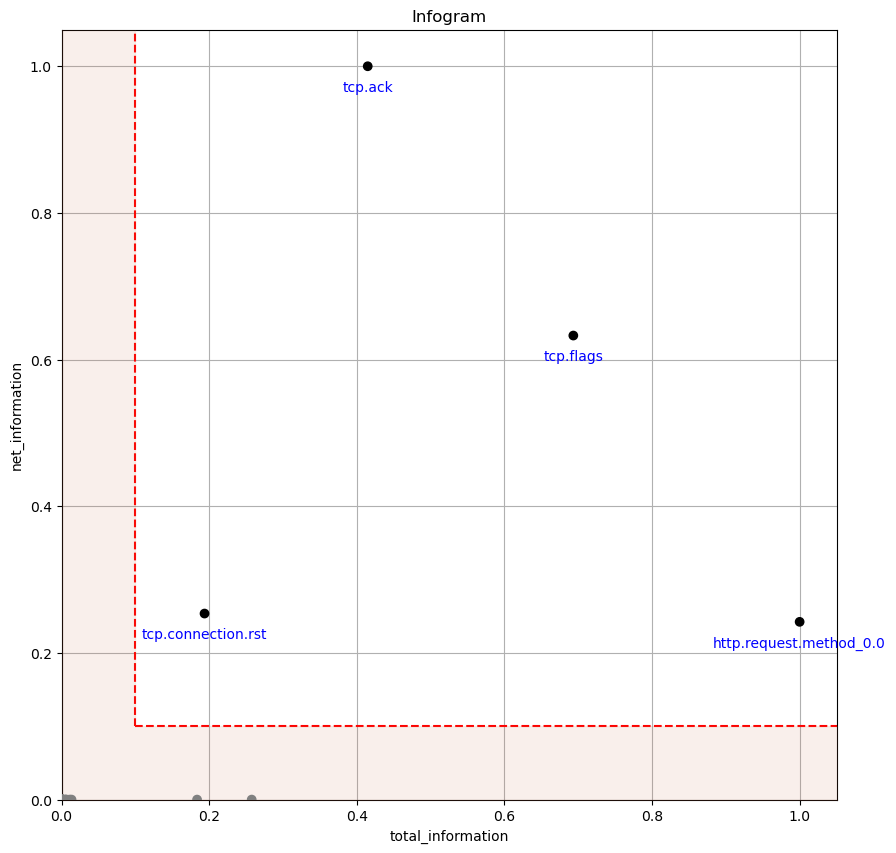

In [10]:
Fea = CSHFeature()
Fea.load(df_data,x_columns = col_x, y_column=col_y,is_regression = False)
ig = Fea.get_inform_graph("AUTO")
ig.plot()

# Train and test with raw features

## Features to be add noised

In [11]:
dtypes_dict = df_raw.dtypes.to_dict()
noised_columns = []
for f,t in dtypes_dict.items():
    if t in ['int','int64','float','bool']:
        if f != col_y:
            noised_columns.append(f)
print("Total noised columns",len(noised_columns),len(col_x))

Total noised columns 37 37


## Create dataset

In [12]:
def add_noise(df_input,ratio=0.1):
    df_data = df_input.copy(deep = True)
    for feature in df_data.keys().tolist():
        if feature in ['Attack_label']:
            continue
        dtypes_dict = df_input.dtypes.to_dict()
        type = dtypes_dict[feature]
        df_data[feature] = CIoTNoise.add_noise(feature,type,df_data,ratio)
    return df_data

def train_test(df_train,df_test):
    model = CSHModelClassify()
    model.train(df_train,x_columns=col_x,y_column=col_y,train_ratio = 0)
    df_importance = model.importance()
    df_result = pd.DataFrame()
    for ratio in tqdm([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
        df_test_noised = add_noise(df_test,ratio=ratio)
        df_verify_noised = model.evaluate(df_test_noised,x_columns=col_x,y_column=col_y)
        df_verify_noised['ratio'] = ratio
        df_result = pd.concat([df_result,df_verify_noised],ignore_index=True)
    df_result = df_result.reset_index(drop=True)
    return df_importance,df_result

## Train the model using all features to validate its noise resistance.

In [13]:
df_data = df_raw.copy(deep = True)
df_train,df_test = CSHSample.split_dataset(df_data)
df_importance,df_verify = train_test(df_train,df_test)
df_verify.to_csv("./IIoTSet/result/binary-classification-46-features-without-normalization.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


  0%|          | 0/11 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

## Train the model using all features to validate its noise resistance.

In [14]:
df_data = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 
df_tmp = df_data.copy(deep = True)
scale_colums = []
for key,type in zip(df_tmp.keys(),df_tmp.dtypes):
    if not type in ["bool","object","category"] and not key in [col_y]:
        scale_colums.append(key)
    if df_tmp[key].dtype =='bool':
        df_tmp[key] = df_tmp[key].astype(int)
for key in scale_colums:
    df_tmp[key] = (df_tmp[key]-df_tmp[key].min())/(df_tmp[key].max()-df_tmp[key].min()) + 1
    df_tmp[key],l = CSHDataProcess.normal_transform(df_tmp[key])
    
df_train,df_test = CSHSample.split_dataset(df_tmp)
df_importance,df_verify = train_test(df_train,df_test)
df_verify.to_csv("./IIoTSet/result/binary-classification-46-features.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


  0%|          | 0/11 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

## Train the model using only 4 features to validate its noise resistance

In [15]:
df_data = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 
df_tmp = df_data.copy(deep = True)
scale_colums = []
for key,type in zip(df_tmp.keys(),df_tmp.dtypes):
    if not type in ["bool","object","category"] and not key in [col_y]:
        scale_colums.append(key)
    if df_tmp[key].dtype =='bool':
        df_tmp[key] = df_tmp[key].astype(int)
for key in scale_colums:
    df_tmp[key] = (df_tmp[key]-df_tmp[key].min())/(df_tmp[key].max()-df_tmp[key].min()) + 1
    df_tmp[key],l = CSHDataProcess.normal_transform(df_tmp[key])
    
col_x = ['tcp.ack','tcp.flags','tcp.connection.rst','http.request.method_0.0']
col_y = 'Attack_label'
df_tmp = df_data[col_x]
df_tmp[col_y] = df_data[col_y]
df_train,df_test = CSHSample.split_dataset(df_tmp)
df_importance,df_verify = train_test(df_train,df_test)
df_verify.to_csv("./IIoTSet/result/binary-classification-4-features.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


  0%|          | 0/11 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

# Show experimental results.

In [3]:
def show_result(df_result):
    for model in df_result['model'].unique():
        df_tmp = df_result[df_result['model']==model]
        del df_tmp['model']
        df_tmp = df_tmp.groupby('ratio').mean()
        df_tmp = df_tmp.sort_values(by='ratio').reset_index()
        df_long = pd.melt(df_tmp, 
                          id_vars=['ratio'], 
                          value_vars=['recall', 'precision','accuracy','f1_score'], 
                          var_name='metric', value_name='value')
        sns.barplot(x='ratio', y='value',hue='metric',orient='v',ci=None,data=df_long)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.110), ncol=4)
        plt.xlabel('Noise ratio', fontsize=10)
        plt.ylabel('Metric value', fontsize=10)
        plt.title('Performance of %s'%model, fontsize=12)
        plt.show()

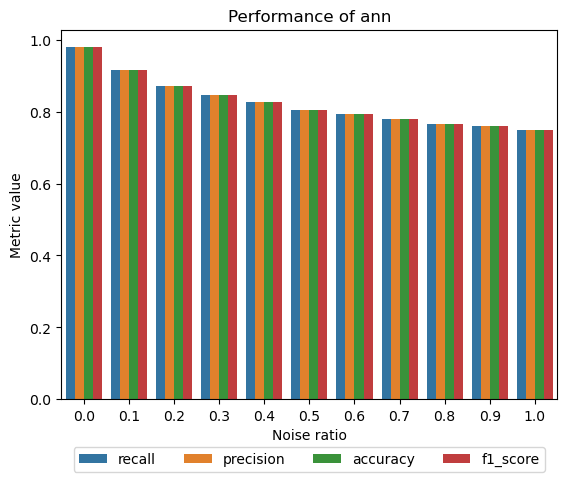

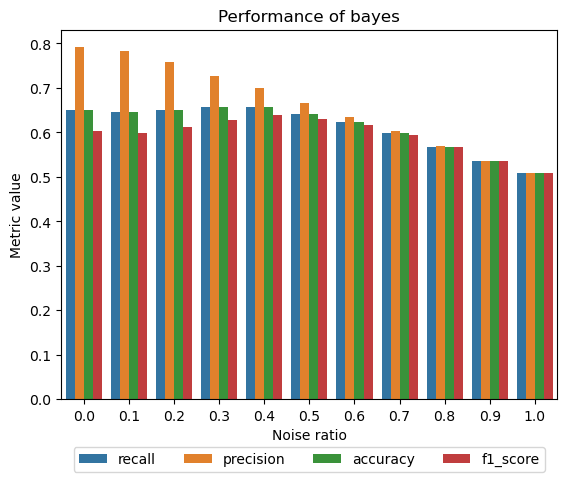

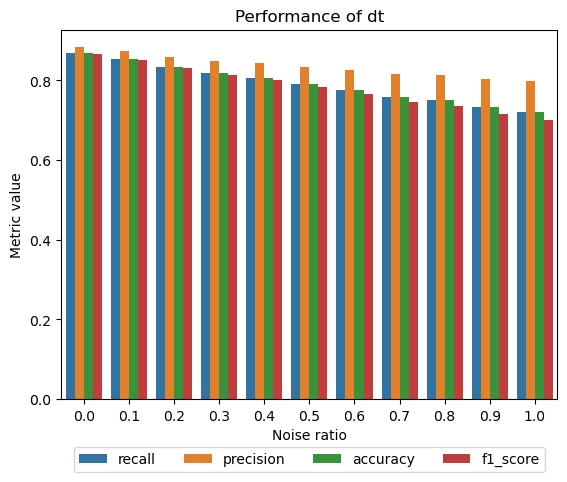

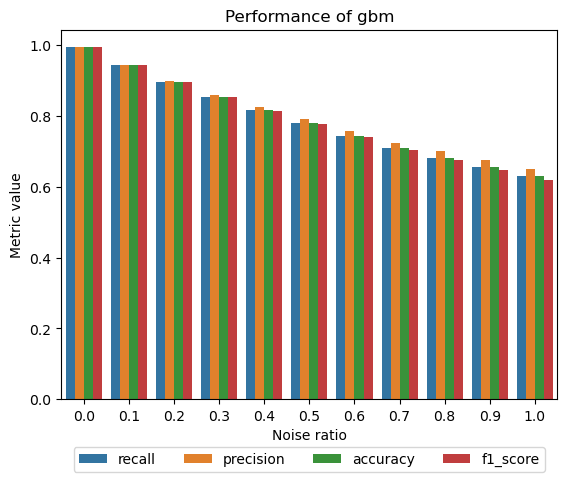

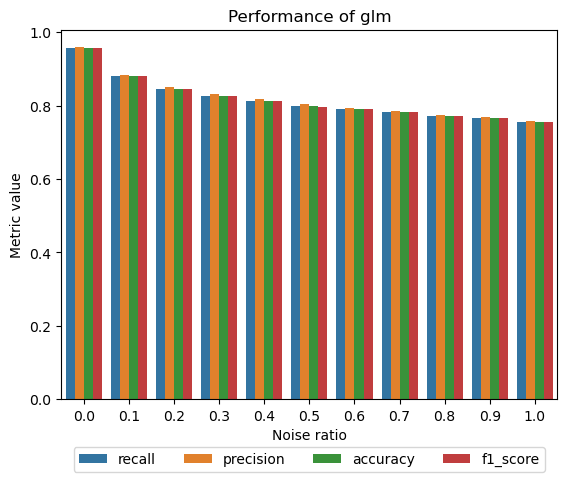

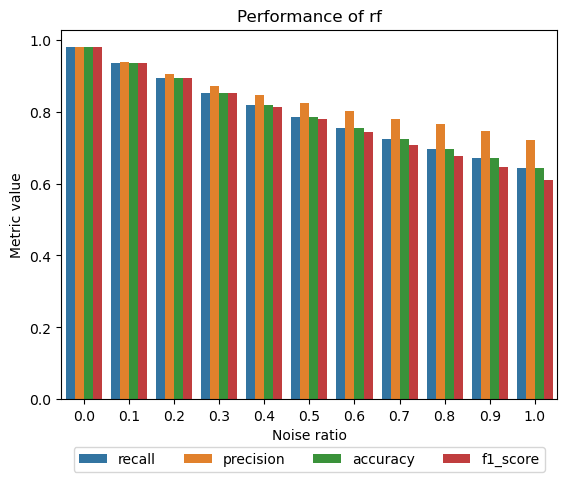

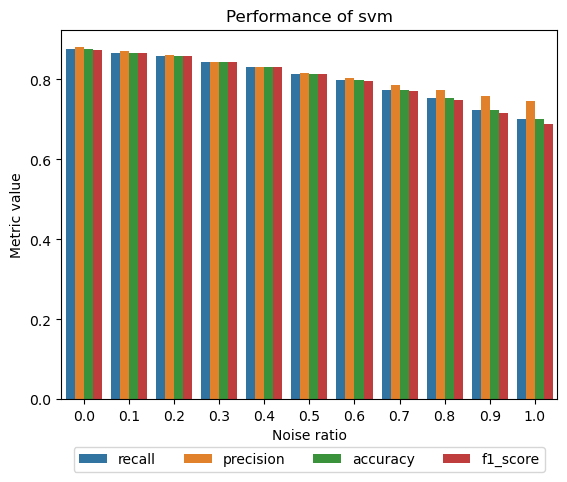

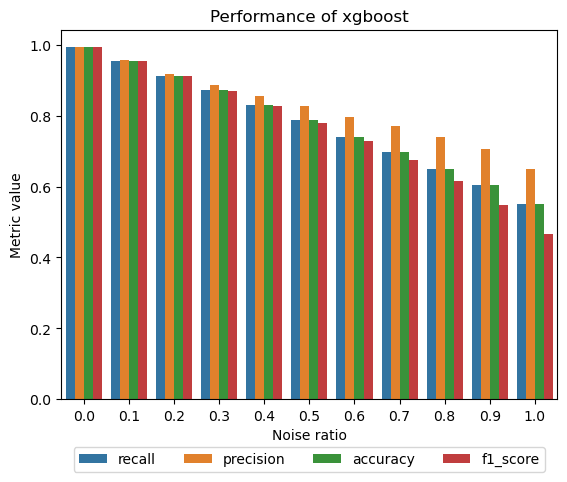

In [6]:
df_result = pd.read_csv("./IIoTSet/result/binary-classification-46-features-without-normalization.csv")
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio']]
show_result(df_result)

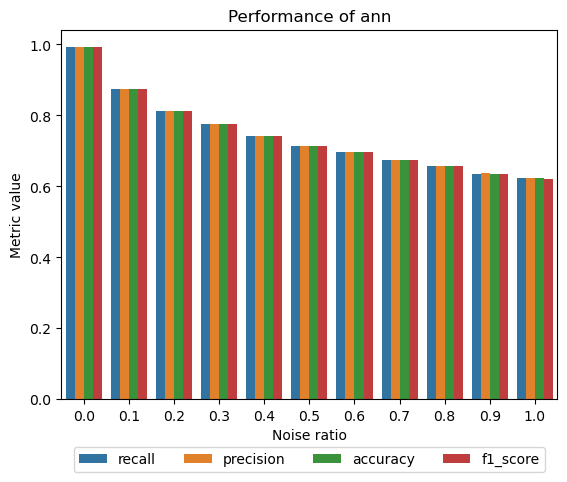

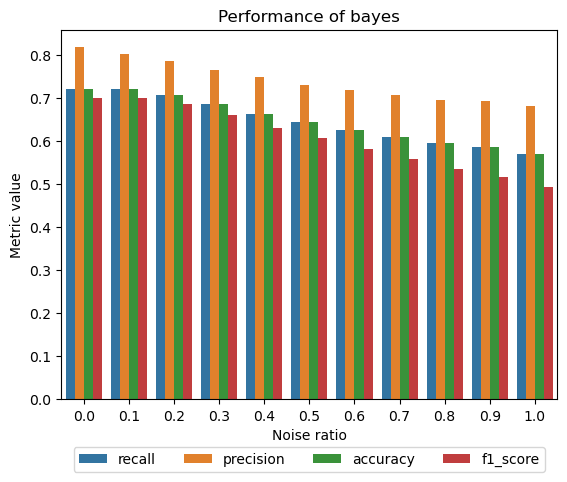

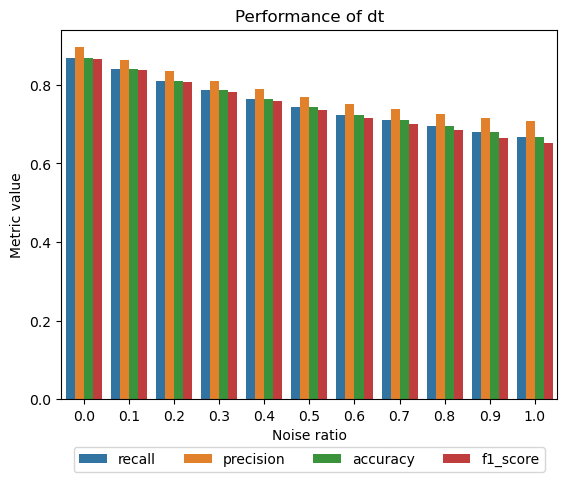

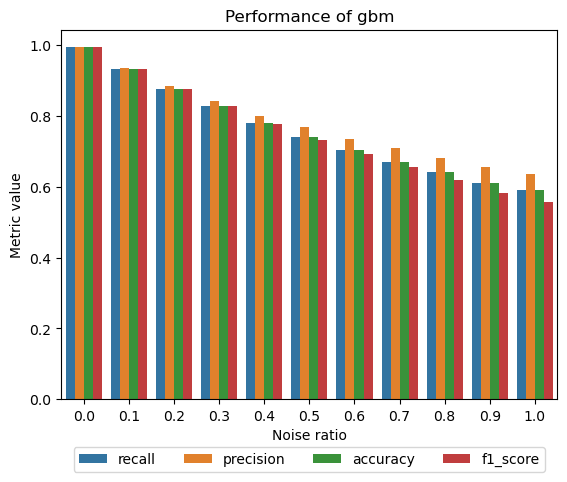

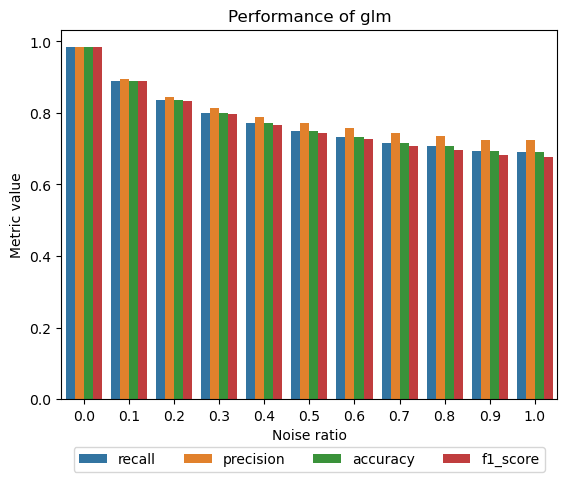

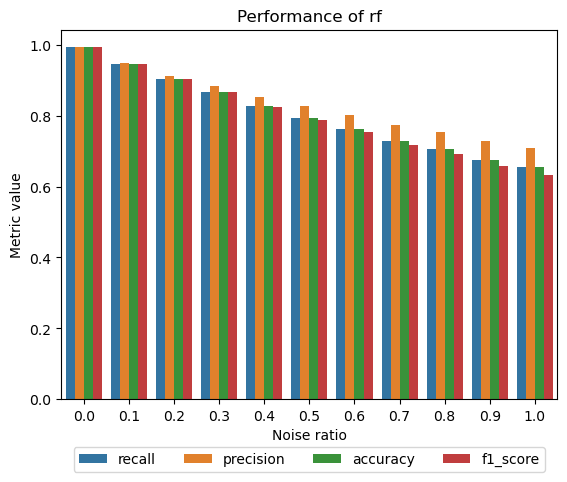

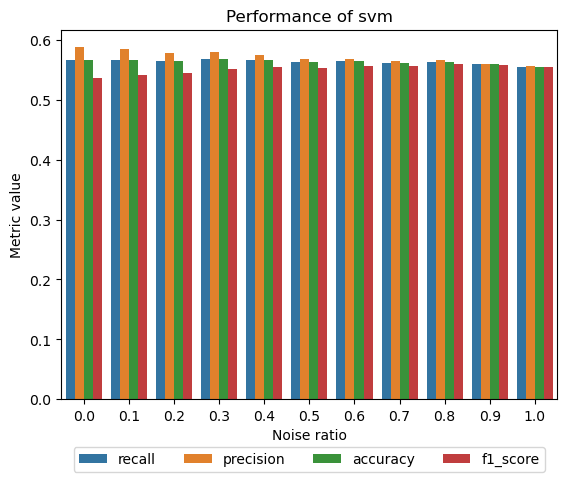

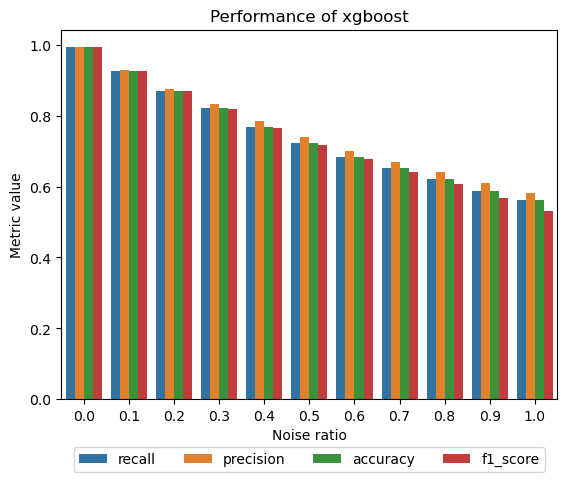

In [7]:
df_result = pd.read_csv("./IIoTSet/result/binary-classification-46-features.csv")
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio']]
show_result(df_result)

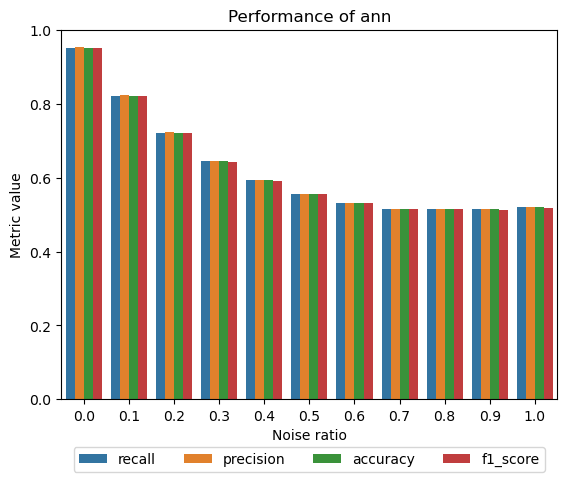

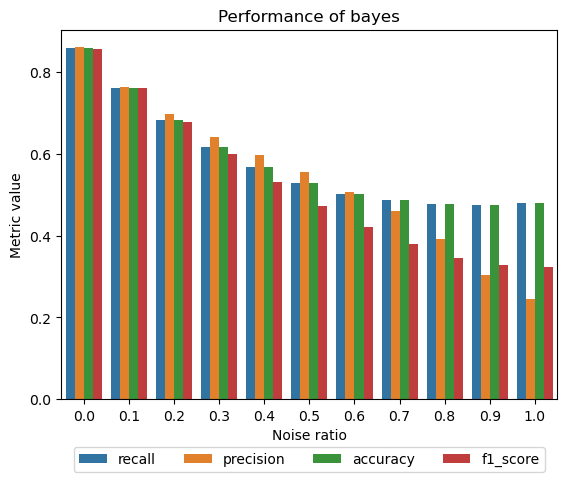

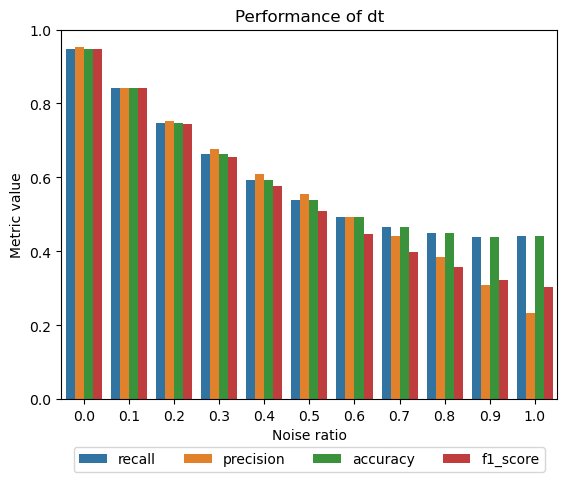

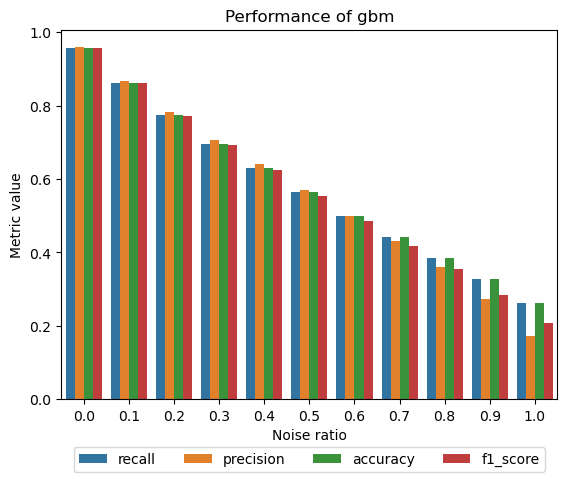

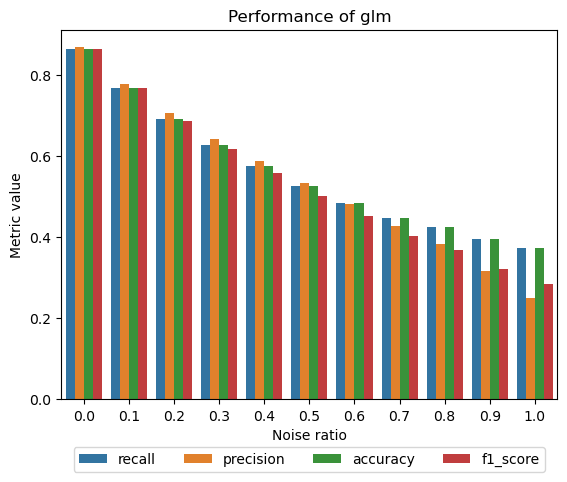

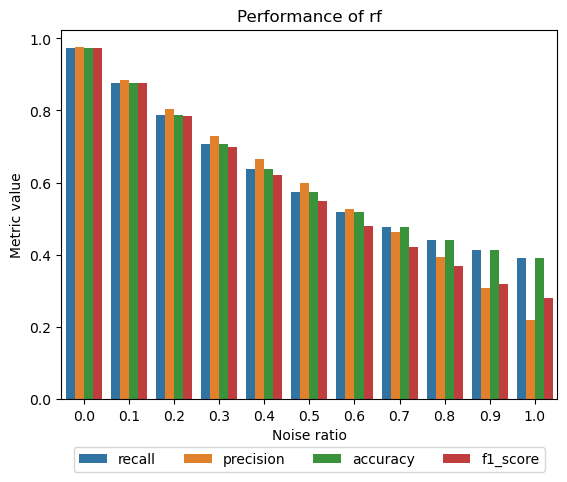

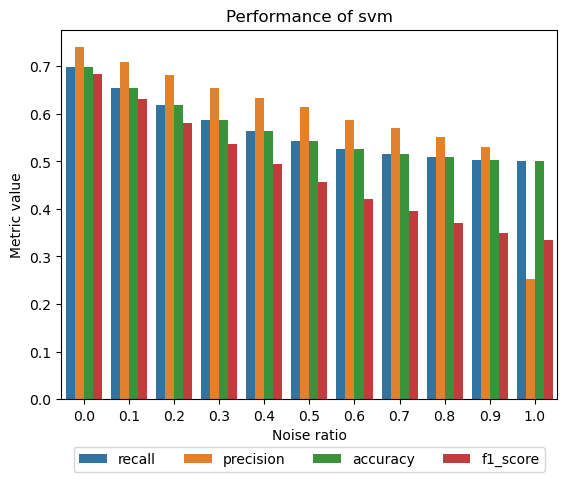

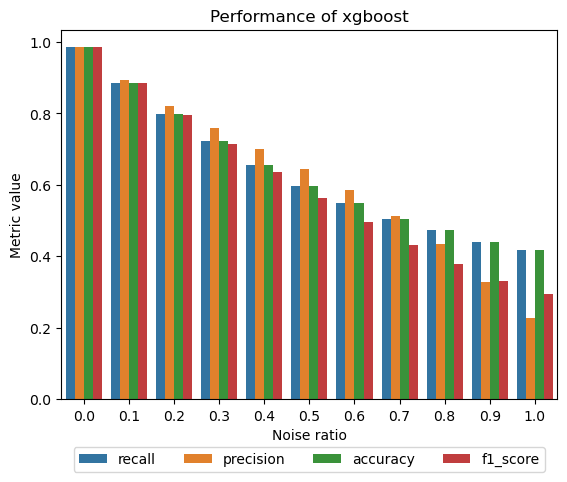

In [8]:
df_result = pd.read_csv("./IIoTSet/result/binary-classification-4-features.csv")
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio']]
show_result(df_result)